# Introduction to Deep Declarative Networks

## 1. What is deep learning

Deep learning is a sub-field of machine learning focusing on **end-to-end** learnable models based on artificial neural networks with multiple layers. 

These neural networks can learn to recognize patterns and make decisions based on input data, without being explicitly programmed.

Notes: end-to-end means the model learns the entire mapping from input to output.

### 1.1 Data-flow diagram of an ANN

First let's think of a deep learning model as a data-flow diagram:

![data](figures/data_flow.png)

This shows how data is processed in a forward pass to arrive some predictions which can be written as:

$$
y = f_8\left(f_4\biggl(f_3\biggl(f_2\bigl(f_1(x)\bigr)\biggr)\biggr), f_7\biggl(f_6\biggl(f_5\bigl(f_1(x)\bigr)\biggr)\biggr)\right)
$$

This defines the output of the network as a composition of functions, each function takes its input as the parent node in the graph


Each processing node in the diagram is responsible for two primary operations:

* Compute the output of its input and parameters in the forward pass
* Compute the gradient of the error signal which respect to its input and parameters given the error signal's gradient which respect to its output in the backward pass

As long as the node can compute the gradient of its output respect to its input, the error signal's gradient can be computed via the chain rule differentiation all the way from the output of the network to its inputs.

<img src="figures/dl_layer.png"  width="70%" height="30%">

### 1.2 The forward and backward passes

#### 1.2.1 Example

Suppose we have a node that implements the Babylonian algorithm:

<img src="figures/bbln_pseudo.png"  width="40%" height="30%">


We can then back-propagate gradients as

$$
\frac{\partial y_t}{\partial y_{t-1}} = \frac{1}{2} \left( 1-\frac{x}{y^2_{t-1}} \right) 
$$
$$
\frac{\partial y_t}{\partial x} = \frac{1}{2y_{t-1}}+\frac{\partial y_t}{\partial y_{t-1}}\frac{\partial y_{t-1}}{\partial x}
$$

Since we know the node that implements the Babylonian algorithm computes:

$$
y = \sqrt{x}
$$

The backward function then can be calculated as:

$$
\begin{aligned}
\frac{\partial{y}}{\partial{x}} &= \frac{1}{2\sqrt{x}}\\
&= \frac{1}{2y}
\end{aligned}
$$

In [1]:
import torch
x = torch.tensor(1., requires_grad=True)
fwd_fcn = x ** 0.5
fwd_fcn.backward(x)
print(x.grad)


tensor(0.5000)


<img src="figures/autograd_example.png" width=70% height=30%>

The implementation of the forward and backward pass can be decoupled. 

Auto-differentiation is an amazing tool to allow us to write forward functions and get the gradients automatically computed. 

But this can be inefficient when the forward functions can not be expressed in closed form. 

Note that we don't have to use the automatic differentiation. 

We can separate the implementation details of the forward and backward passes as long as the backward pass can compute the gradient or even the descent direction.

### 1.3 PyTorch training loop

For the training loop, we'll build the following steps:

| Number | Step name | What does it do? | Code example |
| ----- | ----- | ----- | ----- |
| 1 | Forward pass | The model goes through all of the training data once, performing its `forward()` function calculations. | `model(x_train)` |
| 2 | Calculate the loss | The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are. | `loss = loss_fn(y_pred, y_train)` | 
| 3 | Zero gradients | The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step. | `optimizer.zero_grad()` |
| 4 | Perform backpropagation on the loss | Computes the gradient of the loss with respect for every model parameter to be updated  (each parameter with `requires_grad=True`). This is known as **backpropagation**, hence "backwards".  | `loss.backward()` |
| 5 | Update the optimizer (**gradient descent**) | Update the parameters with `requires_grad=True` with respect to the loss gradients in order to improve them. | `optimizer.step()` |

<!-- ![pytorch training loop annotated](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01-pytorch-training-loop-annotated.png) -->

[reference](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/01_pytorch_workflow.ipynb)

Gradient descent example

<img src="figures/gds.png" width=70%>

### 1.4 Architecture of a classification neural network

| **Hyperparameter** | **Binary Classification** | **Multiclass classification** |
| --- | --- | --- |
| **Input layer shape** (`in_features`) | Same as number of features (e.g. 5 for age, sex, height, weight, smoking status in heart disease prediction) | Same as binary classification |
| **Hidden layer(s)** | Problem specific, minimum = 1, maximum = unlimited | Same as binary classification |
| **Neurons per hidden layer** | Problem specific, generally 10 to 512 | Same as binary classification |
| **Output layer shape** (`out_features`) | 1 (one class or the other) | 1 per class (e.g. 3 for food, person or dog photo) |
| **Hidden layer activation** | Usually [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) (rectified linear unit) but [can be many others](https://en.wikipedia.org/wiki/Activation_function#Table_of_activation_functions) | Same as binary classification |
| **Output activation** | [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) ([`torch.sigmoid`](https://pytorch.org/docs/stable/generated/torch.sigmoid.html) in PyTorch)| [Softmax](https://en.wikipedia.org/wiki/Softmax_function) ([`torch.softmax`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) in PyTorch) |
| **Loss function** | [Binary crossentropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) ([`torch.nn.BCELoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) in PyTorch) | Cross entropy ([`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) in PyTorch) |
| **Optimizer** | [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) (stochastic gradient descent), [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) (see [`torch.optim`](https://pytorch.org/docs/stable/optim.html) for more options) | Same as binary classification |

[reference](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/02_pytorch_classification.ipynb)

Here are some famous activation function

<Figure size 4000x1000 with 0 Axes>

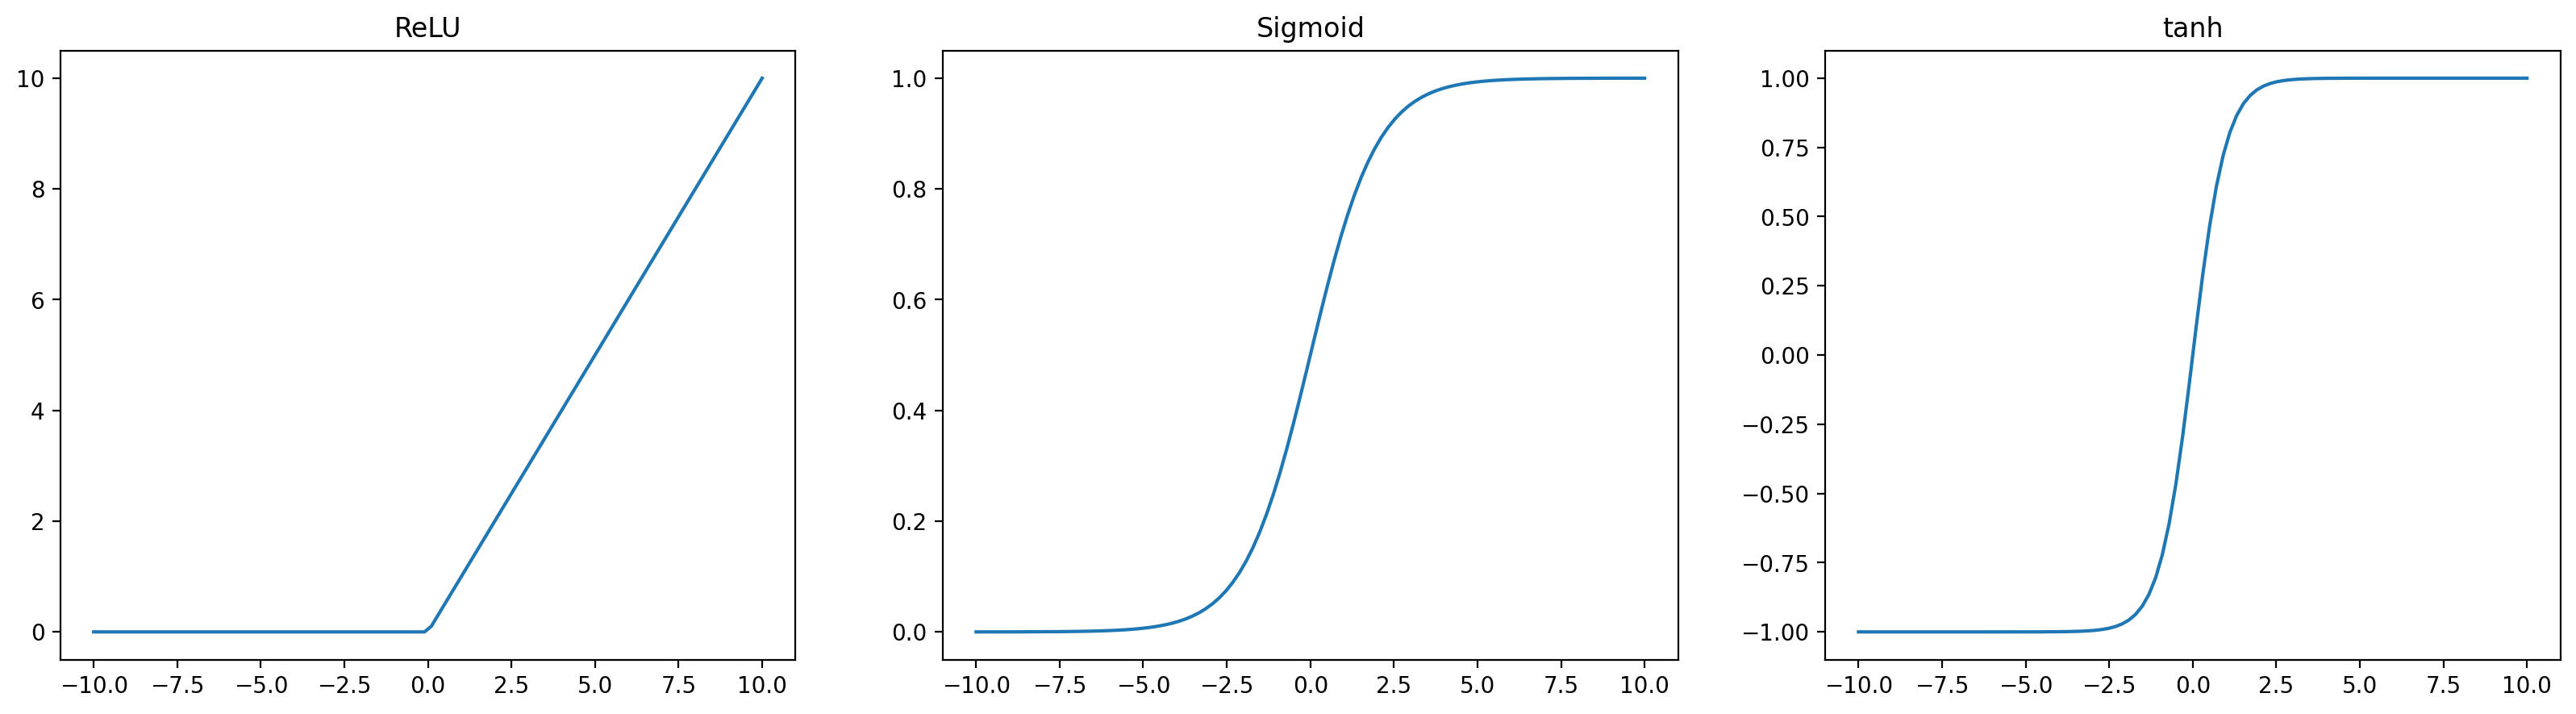

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]
plt.rcParams['figure.dpi'] = 200

x = torch.linspace(-10, 10, 100)
plt.figure()
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.plot(x, torch.relu(x))
ax1.set_title("ReLU")
ax2.plot(x, torch.sigmoid(x))
ax2.set_title("Sigmoid")
ax3.plot(x, torch.tanh(x))
ax3.set_title("tanh")
plt.show()


### 1.5 Different NN's architecture

<img src="https://www.asimovinstitute.org/wp-content/uploads/2019/04/NeuralNetworkZo19High.png" width=75%>

This graph can be found and downloaded at https://www.asimovinstitute.org/neural-network-zoo/.

[TensorFlow](https://www.tensorflow.org) has also built an website where you can [play](https://playground.tensorflow.org/) with simple NN in your browser.

### 1.4 Implicit functions

In most deep learning model we can see, there is an explicit definition of the output of the node given its input. 

That is, we can usually write down a mathematical expression or a simple non-iterative method that will compute the output given the input.

However for the implicit functions, the input and output satisfy a relationship but the output is not given directly by the input.

<img src="figures/implicit_example.png" width=70%>

$$
\psi (x, y) = \left(x-y^2_1+y^2_2\right)^2 + \left(y^2_1+y^2_2-1\right)^2
$$

So given the input $x$, we need a method to find the corresponding $y_1$ and $y_2$ that satisfy the implicit function jointly with $x$.

If we set $\psi(x, y) = 0$ to have a look at the solution space

<img src="figures/soln_space.png" width=70%>

### 1.5 The DDNs

The traditional deep learning architecture is a composition of simple feed-forward processing functions that are explicitly defined.

When it comes to deep learning models with embedded differentiable optimization problems inside.

We can use the form of optimization problem to represent the previous implicit function:

$$
\begin{aligned}
\min_y \quad & \left(x-y_1^2+y_2^2\right)^2 \\
\text{subject to} \quad & \| y \|^2  = 1 \\
\end{aligned}
$$

<img src="figures/d_node.png" width=50%>

#### 1.5.1 The application of deep declarative nodes

<img src="figures/ddn_diagram.png">

$$
y = f_8\left(f_4\biggl(\text{argmin}f_3\biggl(f_2\bigl(f_1(x)\bigr)\biggr)\biggr), \text{argmin}f_7\biggl(f_6\biggl(f_5\bigl(f_1(x)\bigr)\biggr)\biggr)\right)
$$

#### 1.5.2 Backward propagation

Assuming we can solve the optimization problem in the forward pass, the main question in DDNs is now how to calculate the backward pass 

$$
\frac{d}{dx}\text{argmin}_{u\in C(x)}f(x, u)
$$



With the nice property of implicit function theorem and the KKT conditions, we can find the solution set $Y(x):\mathbb{R}^n \rightarrow \mathbb{R}^m$ defined by $x \in \mathbb{R}^n$ as

$$
Y(x) = \text{argmin}_u \{ f(x, u): h(x, u) = 0_p, g(x, u) \leq 0_q \}
$$

and its corresponding derivative 

$$
\frac{dy}{dx} = H^{-1}A^\top (AH^{-1}A^\top)(AH^{-1}B-C)-H^{-1}B
$$

A detailed proof can be found in ["Deep Declarative Networks: A New Hope"](https://arxiv.org/abs/1909.04866).

#### 1.5.3 A quick sum

The main difference between deep declarative nodes and traditional nodes is in forward and backward passes.

* Forward pass
    * A method to solve the optimization problem
* Backward pass
    * Optimality conditions
    * Cached result from the forward pass
    * Do **not** need to know how the problem was solved

## 2. The Mean-Variance optimization problem

### 2.1. A quick recap of the model

<!-- Let's consider a portfolio with two assets, each has it's mean-variance $(ER_i, \sigma_i) \text{ with } i \in {0, 1}$ and investment share $\omega$, $(1 - \omega)$. -->

The mean-variance of asset one $(ER_1, \sigma_1)$ and asset two $(ER_2, \sigma_2)$ with investment share $\omega$, $(1 - \omega)$:

$$
\begin{aligned}
ER_p &= \omega ER_1 + (1 - \omega)ER_2 \\
\sigma_p &= \sqrt{\omega^2 \sigma^2 + (1-\omega)^2 \sigma^2 + 2\omega(1-\omega)\rho_{12}\sigma_1\sigma_2}
\end{aligned}
$$

where $\rho$ is the correlation between the two investments.


Our goal is to find the "minimum-variance frontier" of portfolios that have minimum variance for a given mean return.

Let $\omega$ be a vector of portfolio weight and $R$ be a vector of asset returns with mean $\bar{R}$, then,

* the return is $\omega^\top R$
* the variance is 
  $$
  \mathbb{E} [(\omega^\top R - \omega^\top \bar{R})(\omega^\top R - \omega^\top \bar{R})^\top] = \omega^\top \Sigma \omega
  $$

Then we can form a simple LCQP in the form:

$$
\begin{aligned}
\min_\omega \quad & \frac{1}{2} \omega^\top \Sigma \omega \\
\text{subject to} \quad & \omega^\top \bar{R} = \mu \\
& \omega^\top \bold{1} = 1 \\
& \omega \geq 0
\end{aligned}
$$

### 2.2 A general approach

To solve such a convex optimization problem, we usually use the Lagrangian to find the optima:

$$
\mathcal{L}(\omega, \lambda) = \frac{1}{2}\omega^\top\Sigma\omega - \lambda_1(\omega^\top\bar{R} - \mu) - \lambda_2(\omega^\top \bold{1} - 1) - \nu^\top\omega
$$

We can then take the derivative of $\mathcal{L}$ with respect to $\omega$ and solve for the optima.

In some problems where we have really complex constraints, we can then try to find the corresponding dual problem:

$$
g(\lambda, \nu) = \inf_\omega \left(\frac{1}{2}\omega^\top\Sigma\omega - \lambda_1(\omega^\top\bar{R} - \mu) - \lambda_2(\omega^\top \bold{1} - 1) - \nu^\top\omega \right)
$$

and then converting it to the Lagrangian dual problem:

$$
\begin{aligned}
\max \quad & g(\lambda, \nu) \\
\text{subject to} \quad & \lambda \geq 0
\end{aligned}
$$

This can give us nice properties like weak/strong duality and the Slater's condition.

### 2.3 Using `cvxpy` to find the optimum

In [3]:
import cvxpy as cp
import numpy as np

# Define the problem data
n = 5  # number of assets
r = np.array([0.1, 0.2, 0.15, 0.25, 0.3]).T  # expected returns
r_bar = np.average(r)
mu = r_bar
Sigma = np.array([[0.005, -0.010,  0.004,  0.001,  0.002],
                  [-0.010,  0.040, -0.015, -0.005, -0.010],
                  [0.004, -0.015,  0.023,  0.007,  0.008],
                  [0.001, -0.005,  0.007,  0.010,  0.003],
                  [0.002, -0.010,  0.008,  0.003,  0.015]])  # covariance matrix
alpha = 0.5  # risk aversion parameter

# Define the variables and constraints
w = cp.Variable(n)
objective = cp.Minimize(alpha * cp.quad_form(w, Sigma))
constraints = [w @ r == mu, cp.sum(w) == 1, w >= 0]

# Solve the problem
problem = cp.Problem(objective, constraints)
problem.solve(requires_grad=True)
problem.backward()

# Print the optimal portfolio weights and objective value
print(f"Optimal portfolio weights: {w.value}")
print(f"Optimal variance: {problem.value}")
print(f"Expected return: {w.value @ r}")
print(w.gradient)


Optimal portfolio weights: [3.41827307e-01 2.09131868e-01 1.14245153e-07 2.14426701e-01
 2.34614011e-01]
Optimal variance: 0.0007644343727108283
Expected return: 0.1999999998751394
None


## 3. A DDNs approach to the mean-variance optimization problem 

### 3.1 Creating a deep declarative node from package `ddn`

In [4]:
from ddn.basic.node import *
import warnings
import scipy.optimize as opt

warnings.filterwarnings('ignore')


class Node(GeneralConstDeclarativeNode):
    def __init__(self, n):
        pass

    def objective(self, x):
        return alpha * np.dot(np.dot(x.T, Sigma), x)

    def constraint1(self, x):
        return np.dot(np.ones((1, n)), x) - 1

    def constraint2(self, x):
        return np.dot(r, x) - r_bar

    def solve(self):
        # Solve the constrained optimization problem using scipy's built-in minimize function. Here we
        # initialize the solver at the uniform distribution.
        x0 = np.abs(np.random.randn(n).T)
        x0 = x0/np.sum(x0)
        constraints = [{'type': 'eq', 'fun': self.constraint1},
                       {'type': 'eq', 'fun': self.constraint2},
                       {'type': 'ineq', 'fun': lambda x: x}]
        result = opt.minimize(self.objective, x0, constraints=constraints)

        # The solve function must always return two arguments, the solution and context (i.e., cached values needed
        # for computing the gradient). In the case of linearly constrained problems we do not need the dual solution
        # in computing the gradient so we return None for context.
        return result.x, None


In [5]:
# Test the node
node = Node(5)
y, _ = node.solve()
print(f"Expected Output: {w.value}")
print(f"Actual output:   {y}")


Expected Output: [3.41827307e-01 2.09131868e-01 1.14245153e-07 2.14426701e-01
 2.34614011e-01]
Actual output:   [3.41844884e-01 2.10360272e-01 5.55653613e-19 2.11899919e-01
 2.35894925e-01]


### 3.2 A simple implementation of deep declarative nodes

https://anucvml.github.io/ddn-eccvt2020/

In [24]:
# Define the model
class Net(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.nn.functional.leaky_relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define the loss function
class PortfolioVarianceLoss(torch.nn.Module):
    def forward(self, weights, cov_matrix):
        variance = torch.matmul(torch.matmul(weights, cov_matrix), weights.T)
        return variance


# Define the optimizer
model = Net(5, 5, 5)
loss_fn = PortfolioVarianceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
cov_matrix = torch.from_numpy(Sigma).float()
inputs = torch.from_numpy(r).float()

# Train the model
for epoch in range(50):
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = loss_fn(outputs, cov_matrix)
    loss.backward()
    optimizer.step()
    # Add constraints
    with torch.no_grad():
        for param in model.parameters():
            param.clamp_(0, 1)
        weight_norm = model.fc1.weight / \
            model.fc1.weight.sum(dim=1, keepdim=True)
        model.fc1.weight.copy_(weight_norm)
        weight_norm = model.fc2.weight / \
            model.fc2.weight.sum(dim=1, keepdim=True)
        model.fc2.weight.copy_(weight_norm)

# Evaluate the model
with torch.no_grad():
    outputs = model(inputs)
    loss = loss_fn(outputs, cov_matrix)
    print(loss.item())
print(outputs)


0.004059516359120607
tensor([0.5568, 0.3012, 0.1708, 0.2010, 0.3459])
